# Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
%matplotlib inline

from src.legend import load_vocab
import src.map_drawing as map_drawing
import src.map_generator as mg
from models_src.Support import DatasetGenerator, plot_bbox_preds, plot_mask_preds
import os

from google.cloud import bigquery, storage
from google.auth import default

client = bigquery.Client(location='EU')

full_map_gen_args = {
    'map_args_path': "src/map_args.json",
    'minimap_args_path': "src/minimap_args.json",
    'map_concatenation_args_path': "src/map_concatenation_args.json",
    'parcel_input_args_path': "src/parcel_input_args.json",
    'bigquery_client': client
}
os.chdir(globals()['_dh'][0])

IN_COLAB = False
import os, importlib, sys
def reload_script(module_name):
    importlib.reload(sys.modules[module_name])
    os.chdir(globals()['_dh'][0])
    if IN_COLAB:
      os.chdir('GeoDoc/maps_vectorization')

2023-09-27 08:08:18.656178: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 08:08:18.682587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 08:08:18.866749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 08:08:18.868084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 08:08:19.848206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
vocab = load_vocab()

In [47]:
class cfg:
    ds_batch_size = 16
    target_size = 256
    parcel_input_batch_size = 512
    max_vertices_num = 50
    max_shapes_num = 50
    add_legend = 0
    add_minimap = 0
    output_type = 5
    fold_size = 512
    num_parallel_calls = 2
    test_mode = 1


In [5]:
fmg = mg.full_map_generator(cfg, vocab, **full_map_gen_args)

Parcels memory usage: 6.127 MB


In [6]:
dg = DatasetGenerator(cfg, fmg)

# BBox size distribution

In [5]:
dg.new_dataset(repeat=False, batch=False)

bboxes_collection = []
for features, labels in dg.ds:
    bboxes_collection.append(labels['bbox'])

bboxes = tf.concat(bboxes_collection, axis=0)
print(f'Number of BBoxes: {len(bboxes)}')


Generate new dataset
Number of BBoxes: 10568


(0.0, 50.0)

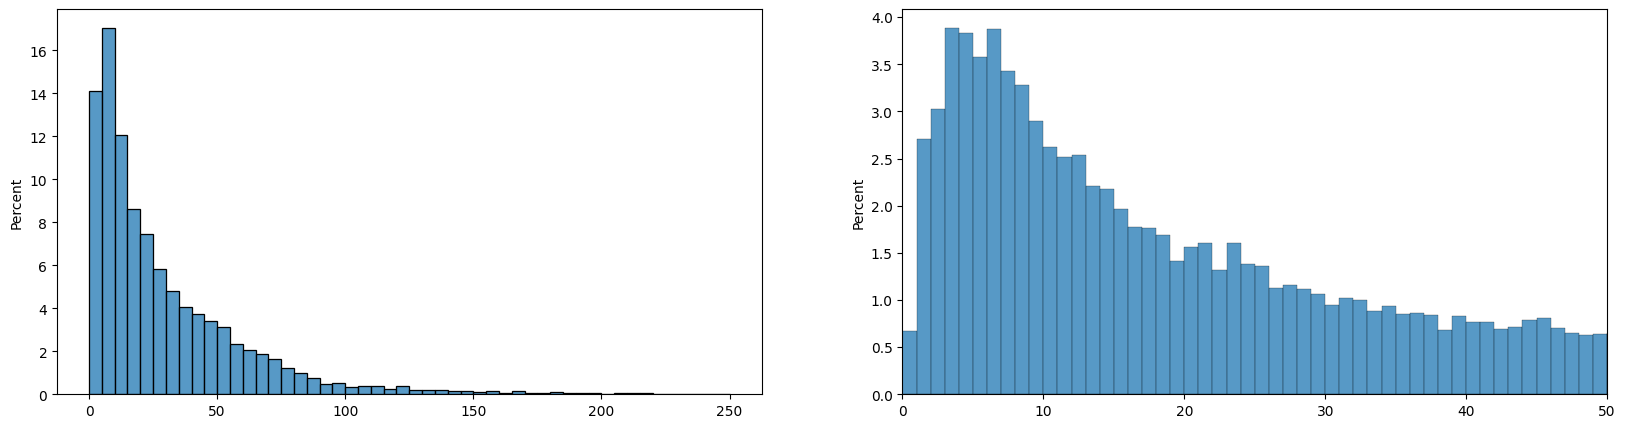

In [15]:
sizes1D = tf.concat([bboxes[:,2]-bboxes[:,0], bboxes[:,3]-bboxes[:,1]], axis=0).numpy()*cfg.target_size

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(sizes1D, binwidth=5, cumulative=False, stat='percent', ax=ax[0])
sns.histplot(sizes1D, binwidth=1, cumulative=False, stat='percent', ax=ax[1])
ax[1].set_xlim(0,50)

# Default anchor function parameters optimization

### Default anchor function

In [7]:
class AnchorGenerator:
    def __init__(self,  
                 base_img_size=(256,256),
                 input_sizes=[64,32,16,8,4]
                 ):
        
        self.height, self.width = base_img_size
        self.input_sizes = input_sizes

        self.bbox_normalization = tf.constant(base_img_size*2, dtype=tf.float32)[tf.newaxis,tf.newaxis]

    def _bbox_decoding(self, bbox):
        YX, HW = bbox[...,:2], bbox[...,2:]*0.5

        return tf.concat([tf.clip_by_value(YX-HW, [0,0], [self.height, self.width]), tf.clip_by_value(YX+HW, [0,0], [self.height, self.width])], axis=-1)

    def _get_anchor_boxes(self, input_size, windows_num, anchor_size, window_size):
        H = W = input_size
        rows = tf.repeat(tf.reshape(tf.range(self.height, delta=self.height//H, dtype=tf.float32), (1,H,1,1)), W, axis=2)
        cols = tf.repeat(tf.reshape(tf.range(self.width, delta=self.width//W, dtype=tf.float32), (1,1,W,1)), H, axis=1)
        grid = tf.concat([cols, rows], axis=-1)

        pool = tf.keras.layers.AveragePooling2D(pool_size=window_size, padding='same')

        centers = tf.reshape(tf.reshape(tf.repeat(tf.expand_dims(pool(grid), axis=-2), self.anchors, axis=-2), (1,windows_num,2*self.anchors)), (1,windows_num*self.anchors,2))

        sizes = tf.stack([tf.constant([anchor_size/scale, anchor_size*scale], dtype=tf.float32) for scale in self.anchor_scales], axis=0) # [3,2]
        sizes =  tf.reshape(tf.repeat(sizes[tf.newaxis, tf.newaxis], windows_num, axis=1), (1, windows_num*self.anchors, 2))

        return self._bbox_decoding(tf.concat([centers, sizes], axis=-1))
    
    def _build(self, anchor_sizes, window_sizes):

        windows_nums = [math.ceil(input_size/window_size)**2 for input_size, window_size in zip(self.input_sizes, window_sizes)]
        #print(f'windows nums: {windows_nums}')

        self.anchor_bboxes = [self._get_anchor_boxes(*args) for args in zip(self.input_sizes, windows_nums, anchor_sizes, window_sizes)]

        self.anchor_output = tf.concat(self.anchor_bboxes, axis=1)

        anchors_num = sum(windows_nums)*self.anchors
        #print(f'all anchors num: {anchors_num}')

    def __call__(self, 
                 anchor_sizes=[24,48,64,156,224], 
                 anchor_scales=[0.5,1.0,2.0], 
                 window_sizes=[1,1,1,1,1],
                 bbox_normalization=True):
        
        self.anchors = len(anchor_scales)
        self.anchor_scales = anchor_scales

        self._build(anchor_sizes, window_sizes)

        if bbox_normalization:
            return self.anchor_output/self.bbox_normalization
        return self.anchor_output

### anchors scoring function

In [17]:
from models_src.Metrics import MultivariantHungarianLoss, IoUMetric

loss = MultivariantHungarianLoss(
                 classification=True,
                 bbox=True,
                 mask=False,
                 losses_weights=[0.0, 1.0, 0.0],
                 output_proposals=50,
                 output_mask_size=(256,256),
                 iou_weight=1.0,
                 bbox_regularization_rank=1,
                 mask_alpha=0.75,
                 mask_gamma=6,
                 mask_pool_size=16,
                 mask_class_pred=True,
                 class_smoothing=0.3,
                 unit_class_matrix=True,
                 reduction='none')

In [9]:
dg.new_dataset(repeat=False, batch=True)

bboxes_batches = []
pb = tf.keras.utils.Progbar(cfg.fold_size//cfg.ds_batch_size)
for features, labels in dg.ds:
    bboxes_batches.append(labels)
    pb.add(1)

print(f'Number of batches: {len(bboxes_batches)}')


Generate new dataset
32/32 [==============================] - 149s 5s/step
Number of batches: 32


In [370]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[6,24,48,64,156,224], 
                anchor_scales=[0.5,1.0,2.0], 
                window_sizes=[1,1,1,1,1,1]
                )
print(anchors.shape)

(1, 28656, 4)


In [10]:
def calc_anchor_scores(loss, bboxes, anchors, batch_size=cfg.ds_batch_size, output_proposals=cfg.max_shapes_num):
    metric = tf.keras.metrics.Mean()
    scores = []
    anchors_batch = {'class': tf.ones((batch_size, anchors.shape[1])), 'bbox': tf.repeat(anchors, batch_size, axis=0)}
    pb = tf.keras.utils.Progbar(len(bboxes), stateful_metrics=['score'])
    for target_batch in bboxes:
        target_batch = {key: value[:,:output_proposals] for key, value in target_batch.items()}
        loss_value, _, _ = loss(target_batch, anchors_batch)
        metric.update_state(1-loss_value)
        scores.append(loss_value)
        pb.add(1, values=[('score', metric.result())])

    return tf.concat(scores, axis=0).numpy()

32/32 [==============================] - 2s 64ms/step - score: 0.4621


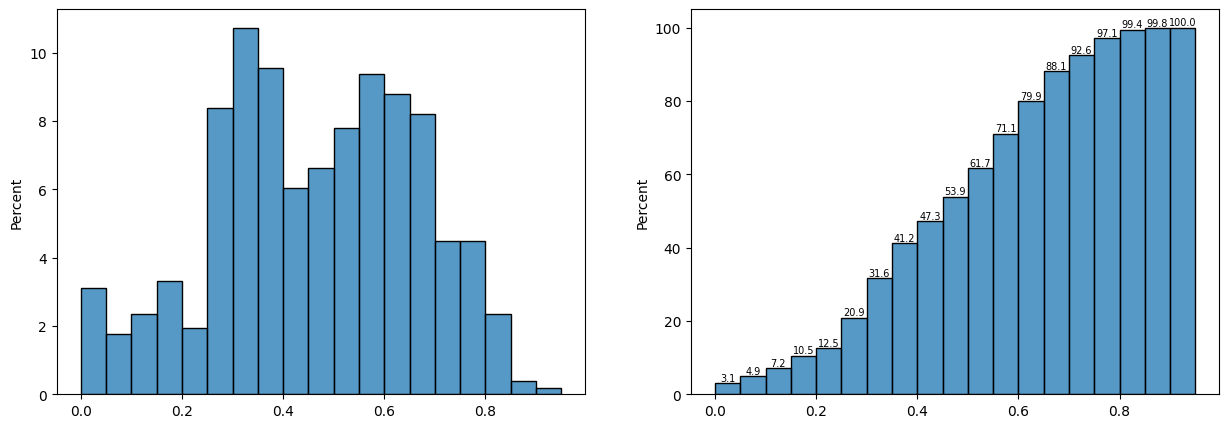

In [371]:
scores = 1-calc_anchor_scores(loss, bboxes_batches, anchors, output_proposals=1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(scores, binwidth=0.05, cumulative=False, stat='percent', ax=ax[0])
sns.histplot(scores, binwidth=0.05, cumulative=True, stat='percent', ax=ax[1])
for i in ax[1].containers:
    ax[1].bar_label(i,fmt='%.1f', fontsize=7)

In [225]:
target_batch = {key: value[:,:1] for key, value in bboxes_batches[1].items()}
loss_value, y_true_match, y_pred_match = loss(target_batch, {'class': tf.ones((cfg.ds_batch_size, anchors.shape[1])), 'bbox': tf.repeat(anchors, cfg.ds_batch_size, axis=0)})
print(1-loss_value), IoUMetric()(y_true_match['bbox'], y_pred_match['bbox'], y_true_match['class'])

tf.Tensor(
[0.23357671 0.3969754  0.7305977  0.234375   0.33517492 0.5481016
 0.046875   0.6697756  0.234375   0.41558444 0.234375   0.49546474
 0.58344597 0.4599998  0.59023666 0.3839122 ], shape=(16,), dtype=float32)


(None, <tf.Tensor: shape=(), dtype=float32, numpy=0.41205287>)

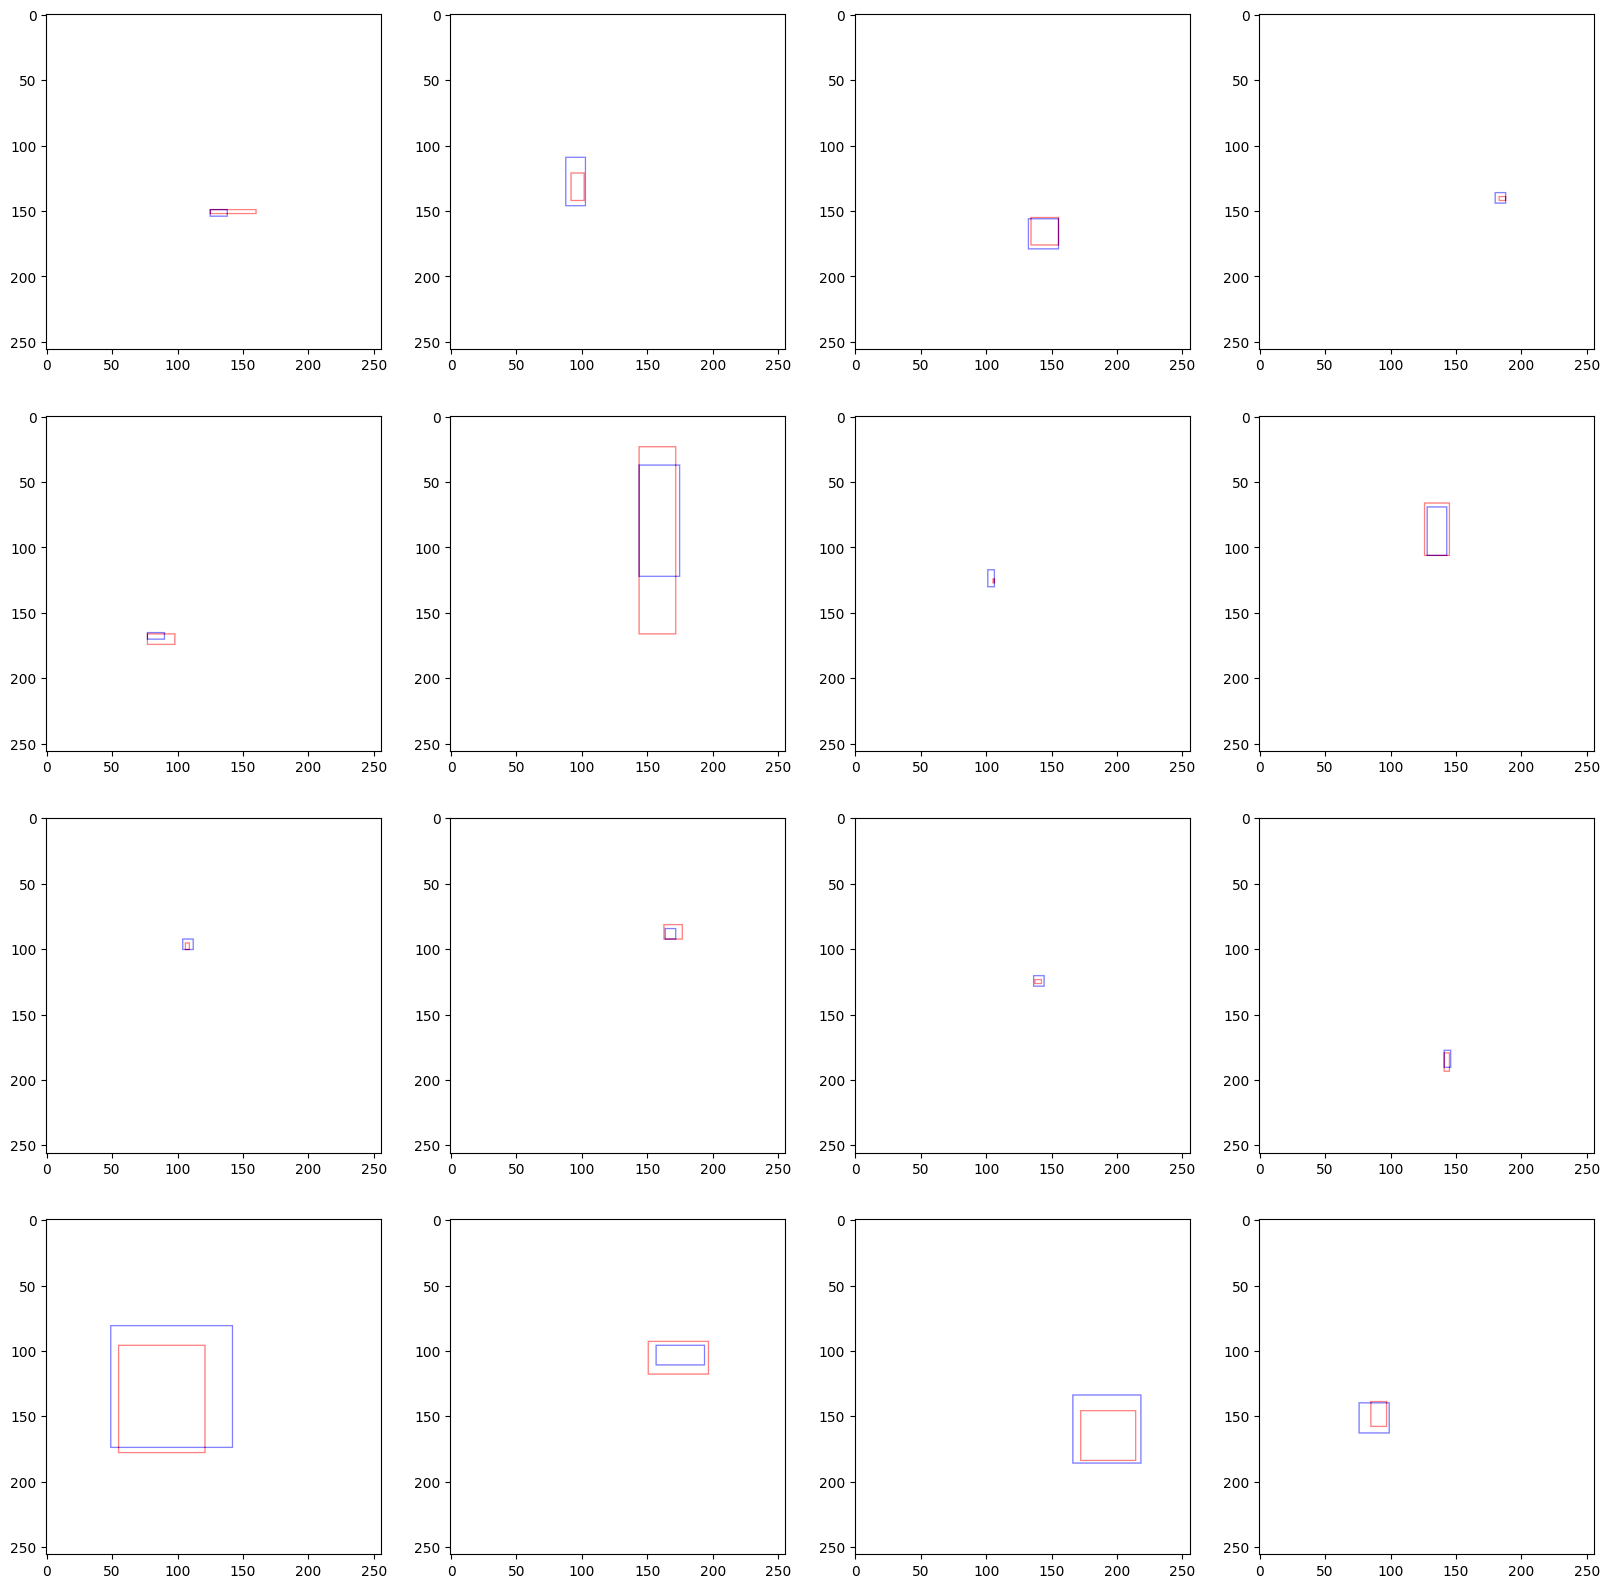

In [224]:
plot_bbox_preds(tf.ones((cfg.ds_batch_size,)+(cfg.target_size,)*2+(3,)), y_true_match, y_pred_match, draw_preds=False, plotsize=5, cols=4)

### Bayesian optimization

In [14]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical, Space
from skopt.utils import use_named_args
np.int = int

In [11]:
class AnchorOptimizer:
    def __init__(self,
                 anchor_generator,
                 bboxes_batches,
                 loss,
                 window_sizes=[1,1,1,1,1],
                 max_anchor_size=cfg.target_size
                 ):
        
        self.anchor_generator = anchor_generator
        self.inputs_num = len(anchor_generator.input_sizes)
        self.bboxes_batches = bboxes_batches
        self.loss = loss
        self.max_anchor_size = max_anchor_size
        self.window_sizes = window_sizes

    def _get_parameters(self, params):
        anchor_additions = params[:self.inputs_num]
        anchor_sizes = [min(self.max_anchor_size,sum(anchor_additions[:i+1])) for i in range(len(anchor_additions))]
        anchor_scales = [1.0]+[scale for base_scale in params[5:] for scale in [base_scale, 1/base_scale]]
        anchor_scales.sort()
        window_sizes = self.window_sizes
        return anchor_sizes, anchor_scales, window_sizes

    def _optimize_func(self, params):
        anchor_sizes, anchor_scales, window_sizes = self._get_parameters(params)

        anchors = self.anchor_generator(anchor_sizes, anchor_scales, window_sizes)

        print(f'anchor_sizes: {anchor_sizes} | anchor_scales: {[round(scale, 2) for scale in anchor_scales]}')
        
        score = np.mean(calc_anchor_scores(self.loss, self.bboxes_batches, anchors))

        return score
    
    def run_experiment(self, search_space, optimizer_args):
        result = gp_minimize(self._optimize_func, search_space, **optimizer_args)

        best_score = result.fun
        anchor_sizes, anchor_scales, window_sizes = self._get_parameters(result.x)
        anchor_scales = [round(scale, 2) for scale in anchor_scales]

        print('Best score: %.3f' % (1-best_score))
        print(f'anchor_sizes: {anchor_sizes} | anchor_scales: {anchor_scales}')

        plt.figure(figsize=(6,4))
        sns.histplot(1-result.func_vals, binwidth=0.01, cumulative=False, stat='percent')

        return result


In [18]:
opt = AnchorOptimizer(
    anchor_generator=AnchorGenerator(input_sizes=[64,64,32,16,8,4]),
    bboxes_batches=bboxes_batches,
    loss=loss,
    window_sizes=[1]*6
)

In [19]:
search_space = [
    Integer(2, 8, name='size5'),
    Integer(2, 8, name='size1'),
    Integer(2, 32, name='size2'),
    Integer(4, 32, name='size3'),
    Integer(8, 64, name='size4'),
    Integer(16, 64, name='size5'),
    Real(0.2,0.8, name='scale1'),
]

optimizer_args = {
    'n_calls': 60,
    'n_random_starts': 10,
    'n_initial_points': 15
}

result = opt.run_experiment(search_space, optimizer_args)

anchor_sizes: [5, 12, 43, 56, 75, 118] | anchor_scales: [0.02, 0.56, 1.0, 1.79, 43]


: 

### scores on BBox sizes

In [12]:
def extract_coords(bbox):
    return bbox[...,0], bbox[...,1], bbox[...,2], bbox[...,3]

def calc_area(Y1,X1,Y2,X2):
    return (X2-X1)*(Y2-Y1)

def calc_bbox_size(Y1,X1,Y2,X2):
    return ((X2-X1)+(Y2-Y1))/2

def IoU(a,b):
    aY1, aX1, aY2, aX2 = extract_coords(a)
    bY1, bX1, bY2, bX2 = extract_coords(b)

    xI = tf.clip_by_value(bX2, aX1, aX2) - tf.clip_by_value(bX1, aX1, aX2)
    yI = tf.clip_by_value(bY2, aY1, aY2) - tf.clip_by_value(bY1, aY1, aY2)

    I = xI*yI
    U = calc_area(aY1, aX1, aY2, aX2)+calc_area(bY1, bX1, bY2, bX2)-I

    return tf.math.divide_no_nan(I,U)

def calc_single_batch_bboxwise_scores(target_batch, anchors, score_func=IoU, img_size=cfg.target_size):
    bbox_nums = tf.cast(tf.reduce_sum(target_batch['class'], axis=1), tf.int32)
    flat_bboxes = tf.concat([example[:n] for n, example in zip(bbox_nums, target_batch['bbox'])], axis=0)
    bbox_sizes = calc_bbox_size(*extract_coords(flat_bboxes))*img_size

    anchors_batch = tf.repeat(anchors, len(flat_bboxes), axis=0)
    flat_bboxes = tf.repeat(flat_bboxes[:,tf.newaxis], anchors.shape[1], axis=1)

    scores = tf.reduce_max(score_func(anchors_batch, flat_bboxes), axis=-1)

    return scores, bbox_sizes


def calc_batch_bboxwise_scores(bboxes_batches, anchors, bin_size=5, score_func=IoU, img_size=cfg.target_size):
    scores = []
    bbox_sizes = []
    for target_batch in bboxes_batches:
        outputs = calc_single_batch_bboxwise_scores(target_batch, anchors, score_func, img_size)
        scores.append(outputs[0])
        bbox_sizes.append(outputs[1])

    scores = tf.concat(scores, axis=0)
    bbox_sizes = tf.concat(bbox_sizes, axis=0)

    print('Overall score: {:.3f}'.format(np.mean(scores)))

    size_limit = int(max(bbox_sizes))+bin_size
    scores_df = pd.DataFrame({'scores': scores.numpy(), 'sizes': bbox_sizes.numpy()})
    agg_scores_df = scores_df.groupby(pd.cut(scores_df.sizes, bins=np.arange(0,size_limit,bin_size))).scores.agg(avg_score='mean', count='count').reset_index()

    s = np.sum(agg_scores_df['avg_score']*agg_scores_df['count'])
    n = np.sum(agg_scores_df['count'])
    m = s/n
    agg_scores_df['score_impact'] = m-(s-agg_scores_df['count']*agg_scores_df['avg_score'])/(n-agg_scores_df['count'])

    fig, ax = plt.subplots(1,4, figsize=(20,4))

    ax[0].set_title('score & size distribution')
    ax[0].set_ylim(0.0,1.0)
    sns.regplot(scores_df, x='sizes', y='scores', order=3, color='indianred', scatter_kws={'color': 'dodgerblue', 'alpha': 0.4, 's': 5}, ax=ax[0])

    ax[1].tick_params('x', labelrotation=90, labelsize=7)
    ax[1].set_title('average score for size')
    sns.barplot(agg_scores_df, x='sizes', y='avg_score', color='mediumseagreen', ax=ax[1])

    ax[2].tick_params('x', labelrotation=90, labelsize=7)
    ax[2].set_title('sizes count')
    sns.barplot(agg_scores_df, x='sizes', y='count', color='slategray', ax=ax[2])

    ax[3].tick_params('x', labelrotation=90, labelsize=7)
    ax[3].set_title('overall impact on final score')
    sns.barplot(agg_scores_df, x='sizes', y='score_impact', color='coral', ax=ax[3])

    return scores, bbox_sizes

(1, 28656, 4)
Overall score: 0.494


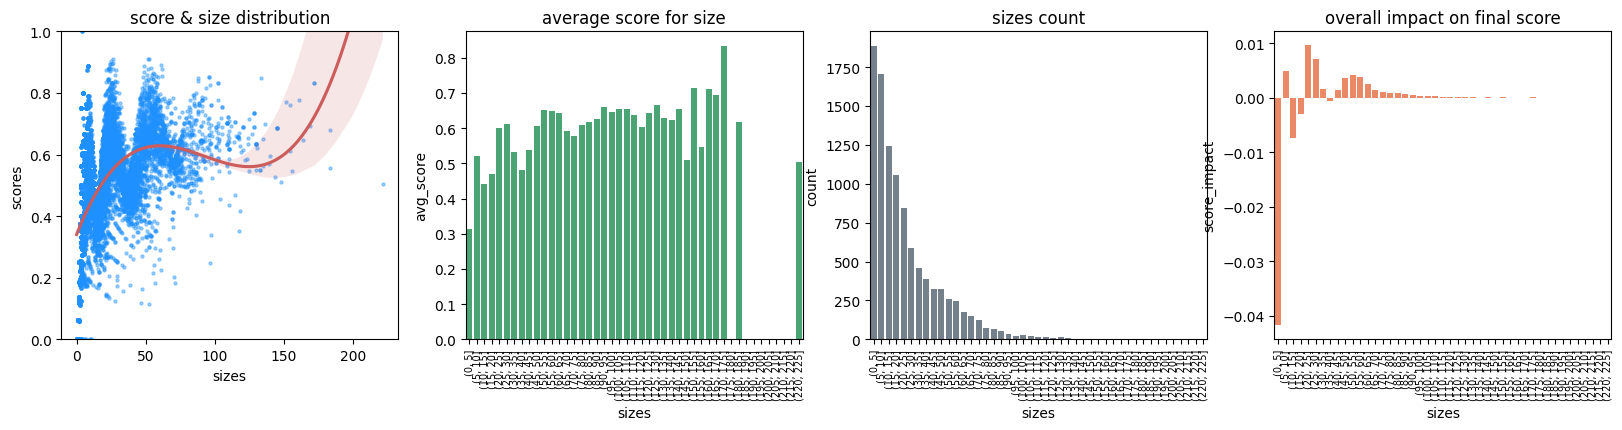

In [13]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[4,8, 23, 52, 93, 157], 
                anchor_scales=[0.61, 1.0, 1.64], 
                window_sizes=[1,1,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

Overall score: 0.469


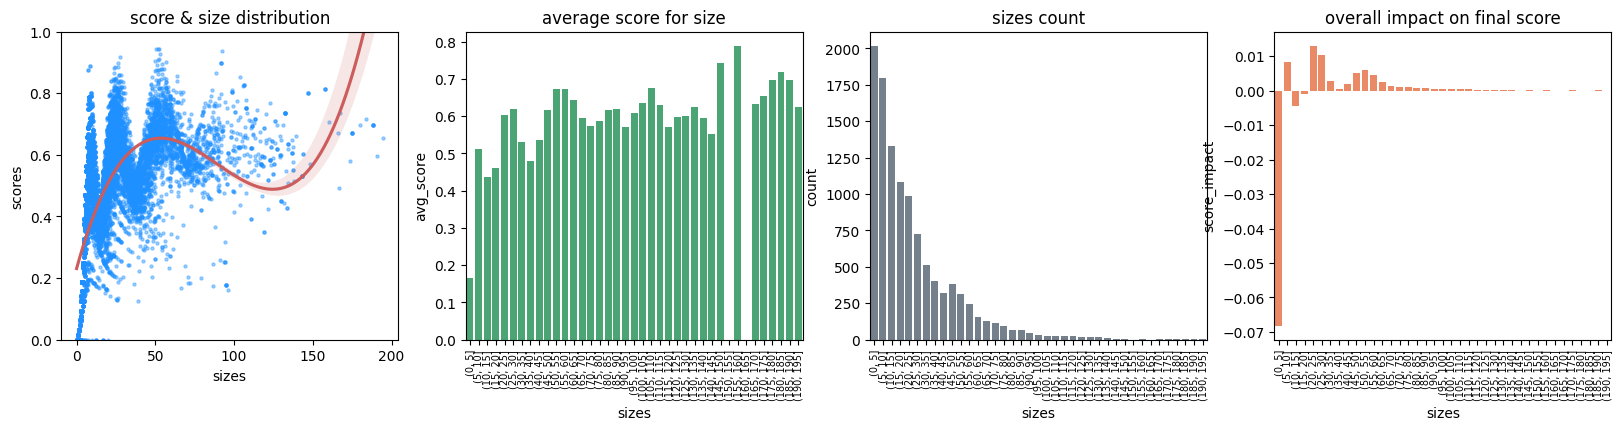

In [365]:
anchors = AnchorGenerator( 
                input_sizes=[64,32,16,8,4]
                 )(
                anchor_sizes=[8, 23, 52, 93, 157], 
                anchor_scales=[0.61, 1.0, 1.64], 
                window_sizes=[1,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

# Input BBox size distribution control

In [189]:
from src.map_drawing import map_drawer_input_generator
import json
from scipy.stats import skewnorm, uniform, describe
from operator import pow, mul

with open(full_map_gen_args['parcel_input_args_path'], "r") as f:
    input_generator_args = json.loads(f.read())

ig = map_drawer_input_generator(client, input_generator_args, batch_size=128, test_mode=1)

In [30]:
parcels_example, background_example = next(ig)
shapes, img_size, padding = parcels_example.values()

In [221]:
def bbox_size_from_input_shape(shape):
    # shape input [N,1,2]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    sizes = XY2-XY1
    return np.mean(sizes)


def relative_input_bbox_sizes(shapes, img_size):
    img_size = np.mean(img_size)

    return np.array([bbox_size_from_input_shape(shape) for shape in shapes])/img_size

def random_shapes_num(patterns_range=(1,20), multishape_prob=0.5, multishape_range=(2,6)):
    patterns_num = np.random.randint(*patterns_range)
    multishapes = np.random.binomial(patterns_num, multishape_prob)
    multishapes_size = np.sum(np.random.randint(*multishape_range, multishapes))

    return multishapes_size+patterns_num-multishapes

def input_distribution_simulation(shapes, img_size, distr_func, distr_args, patterns_range=(1,20), multishape_prob=0.5, multishape_range=(2,6), minimal_size=5/256):
    shapes_num = len(shapes)
    target_shapes_num = min(shapes_num, random_shapes_num(patterns_range, multishape_prob, multishape_range))

    ## filter out small shapes
    max_shapes_to_delete = max(0, shapes_num-target_shapes_num)
    bbox_sizes = relative_input_bbox_sizes(shapes, img_size)

    small_bbox_idxs = np.where(bbox_sizes<minimal_size)[0]
    if (max_shapes_to_delete>0) & (len(small_bbox_idxs)>0):
        idxs_to_delete = np.random.choice(small_bbox_idxs, size=min(max_shapes_to_delete, len(small_bbox_idxs)), replace=False)
        bbox_sizes = np.delete(bbox_sizes, idxs_to_delete, axis=0)
        shapes_num = len(bbox_sizes)
    #######

    probs = distr_func.pdf(bbox_sizes, **distr_args)+1e-5
    probs = probs/np.sum(probs)

    bbox_idxs = np.random.choice(list(range(shapes_num)), size=target_shapes_num, replace=False, p=probs)

    return bbox_sizes[bbox_idxs]

### target BBox size distribution

In [236]:
# INITIAL BBOX SIZE DISTRIBUTION
initial_bbox_dist = np.concatenate([input_distribution_simulation(*list(next(ig)[0].values())[:2], distr_func=uniform, distr_args={'loc': 0.0, 'scale': 1.0}, minimal_size=0) 
                             for _ in range(128)], axis=0)
distr_description = describe(initial_bbox_dist)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))

Mean: 0.10 | Std: 0.11 | Skew: 2.47


In [237]:
# BEST FIT BBOX SIZE DISTRIBUTION
best_fit_dist = np.concatenate([input_distribution_simulation(*list(next(ig)[0].values())[:2], distr_func=skewnorm, distr_args={'a': 15.0, 'loc': 0.31, 'scale': 0.8}, minimal_size=5/cfg.target_size) 
                             for _ in range(128)], axis=0)
distr_description = describe(best_fit_dist)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))

Mean: 0.15 | Std: 0.12 | Skew: 1.72


Mean: 0.28 | Std: 0.18 | Skew: 0.88


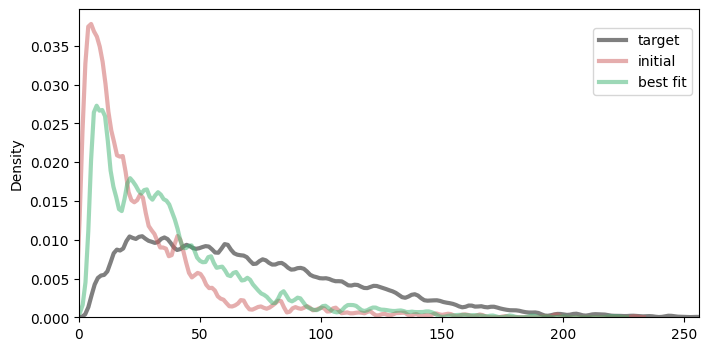

In [243]:
# COMPARISION TO TARGET DISTRIBUTION
fig = plt.figure(figsize=(8,4))
plt.xlim(0, cfg.target_size)

target_distr_sim = skewnorm.rvs(a=8.0, loc=0.03, scale=0.3, size=5000)
target_distr_sim = np.delete(target_distr_sim, np.where((target_distr_sim<5/256) | (target_distr_sim>1)))
distr_description = describe(target_distr_sim)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))
#sns.histplot(target_distr_sim*cfg.target_size, color='black', binwidth=5, stat='probability', alpha=0.5, fill=False, element='step')
#sns.histplot(initial_bbox_dist*cfg.target_size, color='indianred', binwidth=5, stat='probability', alpha=0.3, fill=False, element='step')
#sns.histplot(best_fit_dist*cfg.target_size, color='mediumseagreen', binwidth=5, stat='probability', alpha=0.3, fill=False, element='step')
bw_adjust=0.2
sns.kdeplot(target_distr_sim*cfg.target_size, color='black', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
sns.kdeplot(initial_bbox_dist*cfg.target_size, color='indianred', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
sns.kdeplot(best_fit_dist*cfg.target_size, color='mediumseagreen', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
fig.legend(labels=['target', 'initial', 'best fit'], loc='upper right', bbox_to_anchor=(0.4,0.4,0.5,0.45))

### Shape probability optimization

In [192]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical, Space
from skopt.utils import use_named_args
np.int = int

In [253]:
input_generator_args

{'radius_range': [200, 400],
 'target_map_size_range': [1500, 3000],
 'padding_range': [50, 400]}

In [267]:
custom_ig_args = {
    'radius_range': [150, 300],
    'target_map_size_range': [1500, 3000],
    'padding_range': [50, 100]
}
ig = map_drawer_input_generator(client, input_generator_args, batch_size=512, test_mode=1)

Parcels memory usage: 3.613 MB


In [271]:
class DistOptimizer:
    def __init__(self,
                 input_generator,
                 target_size=256):
        
        self.target_size = target_size
        self.ig = input_generator
        self.ig_len = input_generator.batch_size

    def _eval_distribution(self, params):
        sizes_dist = np.concatenate([input_distribution_simulation(*list(next(ig)[0].values())[:2], 
                                                                   distr_func=self.distr_func, 
                                                                   distr_args={key: value for key, value in zip(self.distr_keys, params[:len(self.distr_keys)])},
                                                                   patterns_range=(1,params[-1]), 
                                                                   minimal_size=self.minimal_size) 
                             for _ in range(self.ig_len)], axis=0)
        
        distr_description = describe(sizes_dist)
        return sizes_dist, distr_description

    def _optimize_func(self, params):
        sizes_dist, distr_description = self._eval_distribution(params)
        score = np.sum([self._calc_single_score(target_measure, distr_description) for target_measure in self.target_measures])
        self.score_metric = min(self.score_metric, score)
        self.pb.add(1, values=[('best score', self.score_metric)])
        #print('{:.8} Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f} | Score {:.3f}'.format(f'{self.i}/{self.n}',distr_description.mean, distr_description.variance**0.5, distr_description.skewness, score))
        return score

    def _calc_single_score(self, target_measure, distr_description):
        value = target_measure['result_operator'](getattr(distr_description, target_measure['stat']), target_measure['operator_arg'])
        score = np.abs(value-target_measure['target_value'])*target_measure['weight']
        return score

    def run_experiment(self, search_space, optimizer_args, distr_func, distr_keys, minimal_size, target_measures, target_distr_sim, initial_bbox_dist, binwidth=5):

        self.target_measures = target_measures
        self.distr_func = distr_func
        self.distr_keys = distr_keys
        self.minimal_size = minimal_size

        self.pb = tf.keras.utils.Progbar(optimizer_args['n_calls'], stateful_metrics=['best score'])
        self.score_metric = 1.0

        result = gp_minimize(self._optimize_func, search_space, **optimizer_args)

        best_score = result.fun
        print('\nBest score: %.3f' % (best_score))
        best_params = result.x
        print('\nBest distr params: %s' % (str({key: value for key, value in zip(self.distr_keys, best_params)})))
        print(f'Best shapes num range: {best_params[-1]}')

        best_fit_dist, best_fit_distr_description = self._eval_distribution(best_params)
        target_distr_description = describe(target_distr_sim)
        print('\nNormalized:')
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Target',target_distr_description.mean, target_distr_description.variance**0.5, target_distr_description.skewness))
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Best fit',best_fit_distr_description.mean, best_fit_distr_description.variance**0.5, best_fit_distr_description.skewness))

        target_distr_description = describe(target_distr_sim*self.target_size)
        best_fit_distr_description = describe(best_fit_dist*self.target_size)
        print('\nScaled:')
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Target',target_distr_description.mean, target_distr_description.variance**0.5, target_distr_description.skewness))
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Best fit',best_fit_distr_description.mean, best_fit_distr_description.variance**0.5, best_fit_distr_description.skewness))


        fig, ax = plt.subplots(1,2, figsize=(14,4))
        ax[0].set_xlim(0, self.target_size)
        ax[1].set_xlim(0, self.target_size)

        ax[0].set_title('Distributions comparision')
        bw_adjust=0.2
        sns.kdeplot(target_distr_sim*self.target_size, color='black', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        sns.kdeplot(initial_bbox_dist*self.target_size, color='indianred', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        sns.kdeplot(best_fit_dist*self.target_size, color='mediumseagreen', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        ax[0].figure.legend(labels=['target', 'initial', 'best fit'], loc='upper right', bbox_to_anchor=(0.4,0.4,0.5,0.45))

        ax[1].set_title('Best fit')
        sns.histplot(best_fit_dist*self.target_size, color='mediumseagreen', binwidth=5, stat='probability', ax=ax[1])

        return result

In [272]:
opt = DistOptimizer(
    input_generator=ig,
    target_size=cfg.target_size
)

100/100 [==============================] - 88s 880ms/step - best score: 0.0718

Best score: 0.072

Best distr params: {'a': 19.061402181474126, 'loc': 0.42695556547178665, 'scale': 1.4655224107185334}
Best shapes num range: 10

Normalized:
Target   -> Mean: 0.28 | Std: 0.18 | Skew: 0.88
Best fit -> Mean: 0.19 | Std: 0.14 | Skew: 1.10

Scaled:
Target   -> Mean: 70.65 | Std: 45.31 | Skew: 0.88
Best fit -> Mean: 49.80 | Std: 36.42 | Skew: 1.10


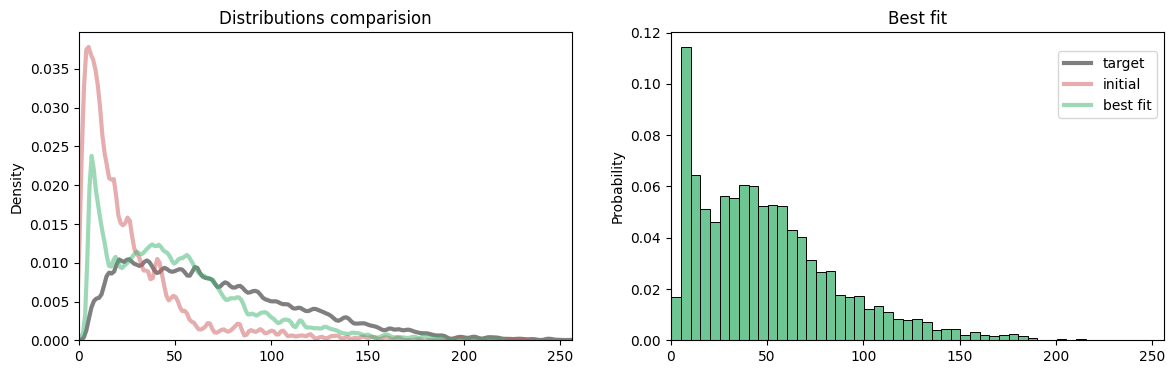

In [276]:
target_measures = [
    {'stat': 'mean', 'target_value': 0.27, 'weight': 0.7, 'result_operator': mul, 'operator_arg': 1},
    {'stat': 'variance', 'target_value': 0.18, 'weight': 0.2, 'result_operator': pow, 'operator_arg': 0.5},
    {'stat': 'skewness', 'target_value': 0.92, 'weight': 0.1, 'result_operator': mul, 'operator_arg': 1}
]

search_space = [
    Real(0.0, 25.0, name='skewness'),
    Real(0.05, 2.0, name='mean'),
    Real(0.05, 3.0, name='std'),
    Integer(10, 20, name='patterns_range')
]

distr_keys = ['a', 'loc', 'scale']

optimizer_args = {
    'n_calls': 100,
    'n_random_starts': 25,
    'n_initial_points': 15
}

result = opt.run_experiment(
    search_space=search_space,
    optimizer_args=optimizer_args,
    distr_func=skewnorm,
    distr_keys=distr_keys,
    minimal_size=5/cfg.target_size,
    target_measures=target_measures,
    target_distr_sim=target_distr_sim,
    initial_bbox_dist=initial_bbox_dist
)

Average shapes number: 11.3293


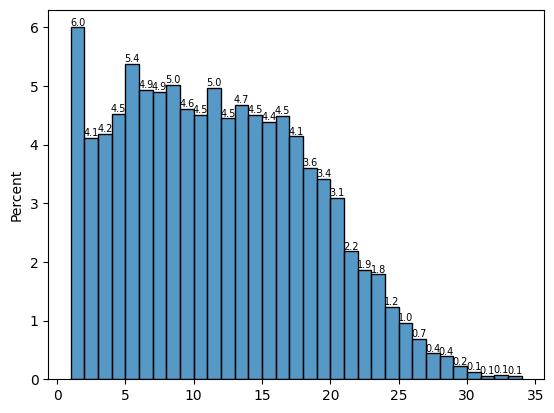

In [277]:
# NUMBER OF SHAPES SIMULATION
shapes_distr = np.array([random_shapes_num(patterns_range=(1,10)) for _ in range(10000)])
print(f'Average shapes number: {np.mean(shapes_distr)}')
ax = sns.histplot(shapes_distr, binwidth=1, cumulative=False, stat='percent')
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f', fontsize=7)

### parcel input adjustment

In [278]:
custom_ig_args = {
    'radius_range': [200, 400],
    'target_map_size_range': [1500, 3000],
    'padding_range': [50, 100]
}
ig = map_drawer_input_generator(client, input_generator_args, batch_size=32, test_mode=1)

Parcels memory usage: 0.573 MB


In [292]:
def bbox_center(shape):
    # input shape [N,1,2]
    # output shape [2]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    return XY1+(XY2-XY1)/2

def bbox_from_input_shape(shape):
    # input shape [N,1,2]
    # output shape [Xmin,Ymin,Xmax,Ymax]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    return np.concatenate([XY1, XY2], axis=0)

In [281]:
shapes, img_size, padding = next(ig)[0].values()

Avg size: 0.029189701115794966 | Shapes num: 271


<Axes: ylabel='Count'>

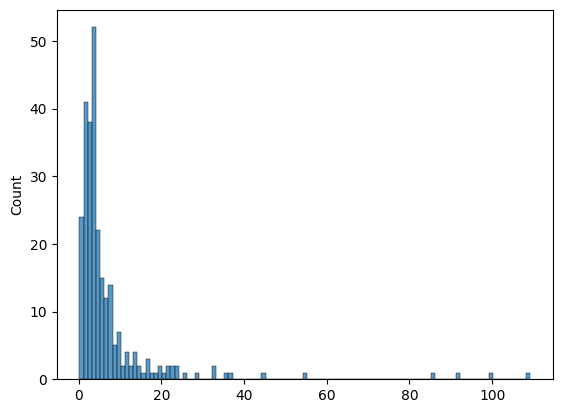

In [287]:
bbox_sizes = relative_input_bbox_sizes(shapes, img_size)
print(f'Avg size: {np.mean(bbox_sizes)} | Shapes num: {len(bbox_sizes)}')
sns.histplot(bbox_sizes*cfg.target_size, binwidth=1)

In [295]:
target_mean_size = 0.28
initial_mean_size = np.mean(bbox_sizes)
approx_window_size = (initial_mean_size/target_mean_size*img_size).astype(np.int32)
print(f'Approx window size: {approx_window_size}')

Approx window size: [210 270]


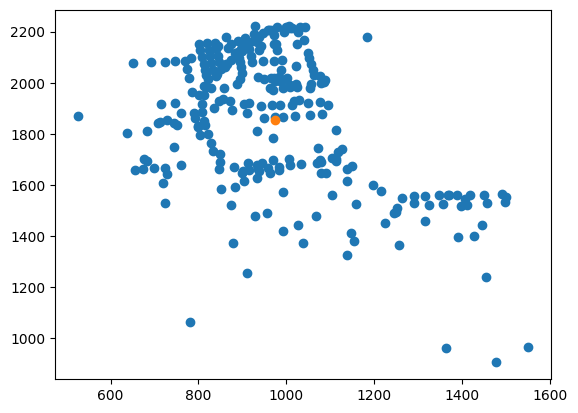

In [303]:
centroids = np.stack([bbox_center(shape) for shape in shapes], axis=1)
center = np.mean(centroids, axis=1)
plt.scatter(*centroids)
plt.scatter(*center)

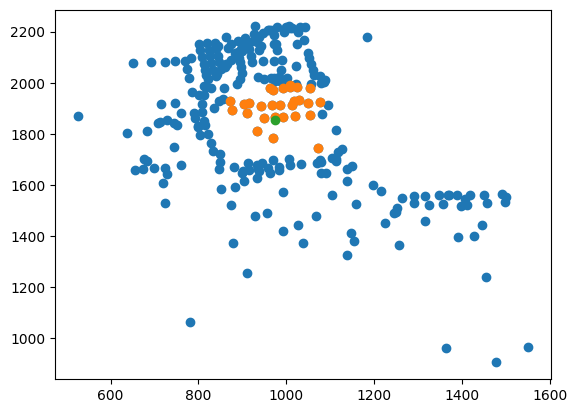

In [310]:
higher = np.all(np.transpose(centroids, axes=[1,0])>(center-approx_window_size/2)[np.newaxis], axis=-1)
lower = np.all(np.transpose(centroids, axes=[1,0])<(center+approx_window_size/2)[np.newaxis], axis=-1)

plt.scatter(*centroids)
plt.scatter(*np.transpose(np.transpose(centroids, axes=[1,0])[np.where(higher*lower)], [1,0]))
plt.scatter(*center)

In [313]:
np.mean(bbox_sizes[np.where(higher*lower)])*img_size/approx_window_size

array([0.24587133, 0.24580378])